In [88]:
import pandas as pd
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, \
    OneHotEncoder

In [2]:
df = pd.read_csv('train .csv')

In [3]:
df["TotalSpent"] = df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
df = df.astype({"TotalSpent": "float64"})
print(len(df))
df = df.drop_duplicates()
print(len(df))

5282
5268


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5268.0,32.480448,24.529439,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5268.0,64.977563,30.176025,18.25,35.5375,70.45,90.0500,118.75
TotalSpent,5268.0,2293.445549,2269.111393,0.00,401.9250,1411.50,3808.6375,8684.80
IsSeniorCitizen,5268.0,0.159643,0.366310,0.00,0.0000,0.00,0.0000,1.00
Churn,5268.0,0.260820,0.439124,0.00,0.0000,0.00,1.0000,1.00


In [6]:
translations = {}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

In [7]:
def churn_by_category(category):
    df.groupby(['Churn', category]).size().unstack(fill_value=0).plot(kind='bar', stacked=True);

In [8]:
df["HasMovieSubscription"] = df["HasMovieSubscription"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasMultiplePhoneNumbers"] = df["HasMultiplePhoneNumbers"].apply(lambda x: "No" if x == "No phone service" else x)
df["HasOnlineSecurityService"] = df["HasOnlineSecurityService"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasOnlineBackup"] = df["HasOnlineBackup"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasDeviceProtection"] = df["HasDeviceProtection"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasTechSupportAccess"] = df["HasTechSupportAccess"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasOnlineTV"] = df["HasOnlineTV"].apply(lambda x: "No" if x == "No internet service" else x)

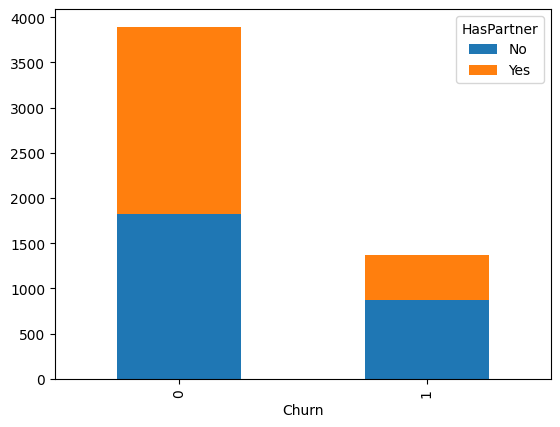

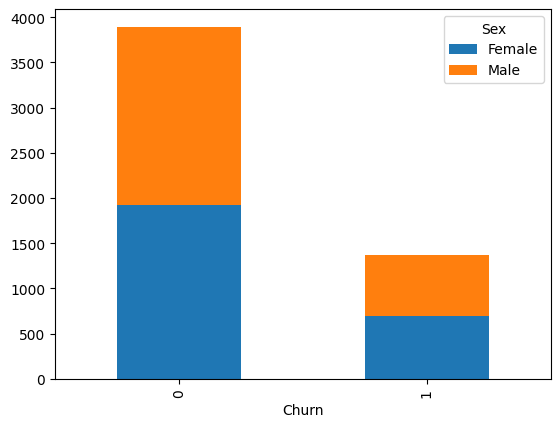

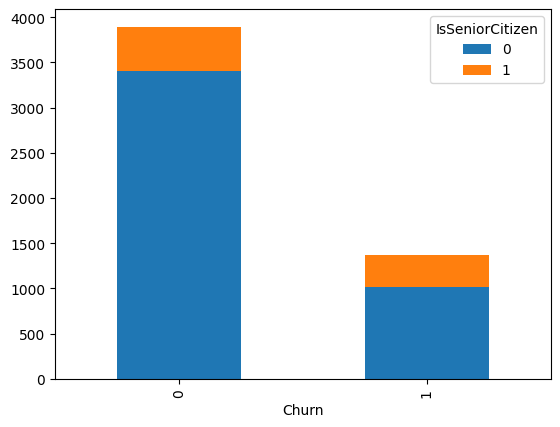

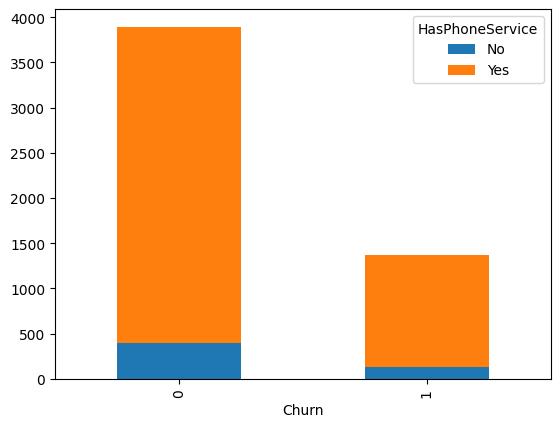

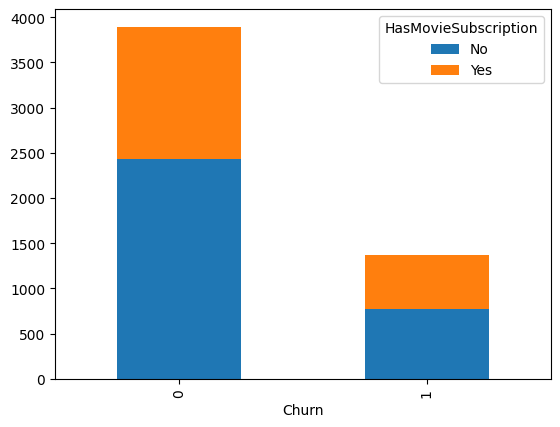

In [9]:
churn_by_category('HasPartner')
churn_by_category('Sex')
churn_by_category('IsSeniorCitizen')
churn_by_category('HasPhoneService')
churn_by_category('HasMovieSubscription')

Колонки HasPartner, Sex, IsSeniorCitizen, HasPhoneService, HasMovieSubscription не влияют на отток.
Удаление столбцов приводит к росту метрики.

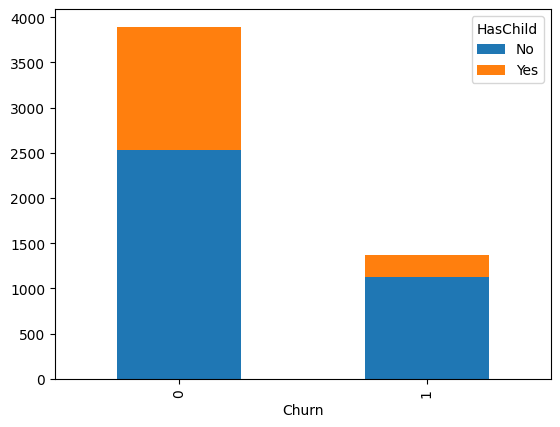

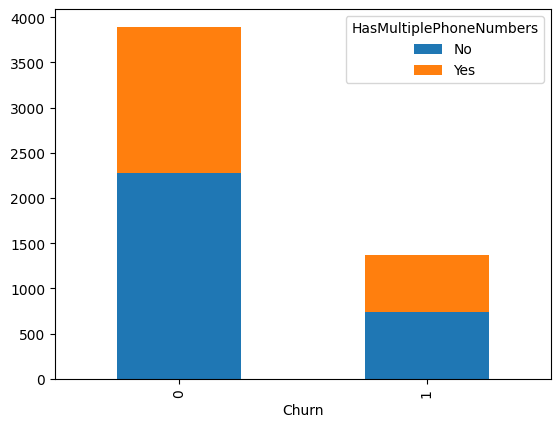

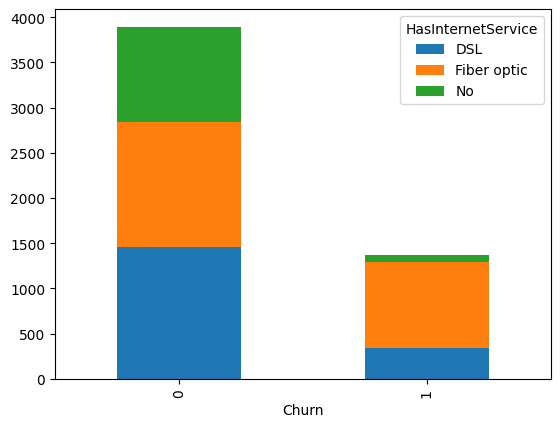

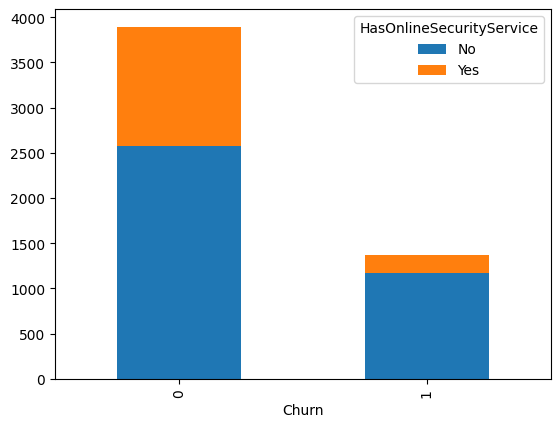

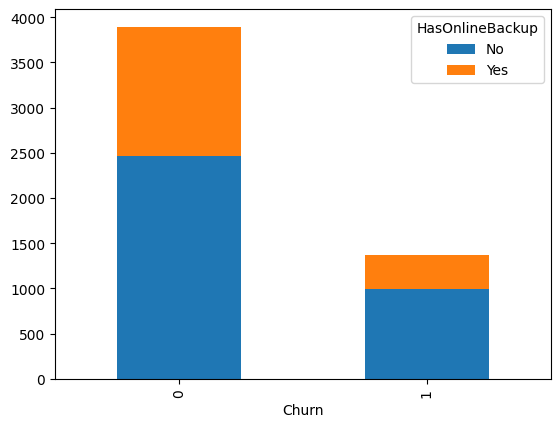

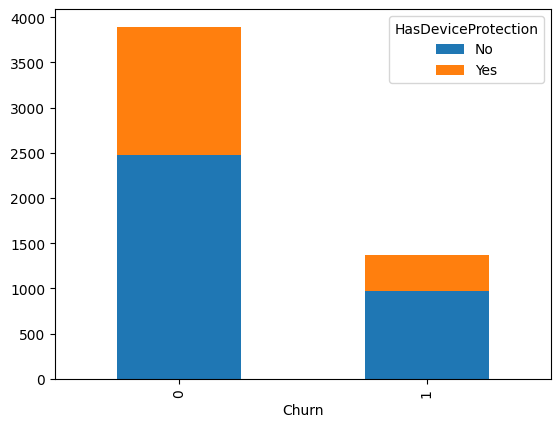

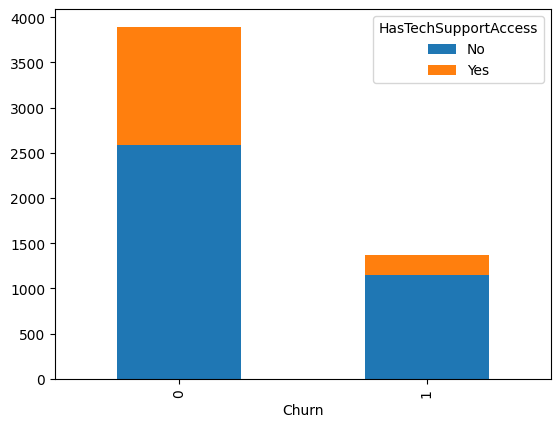

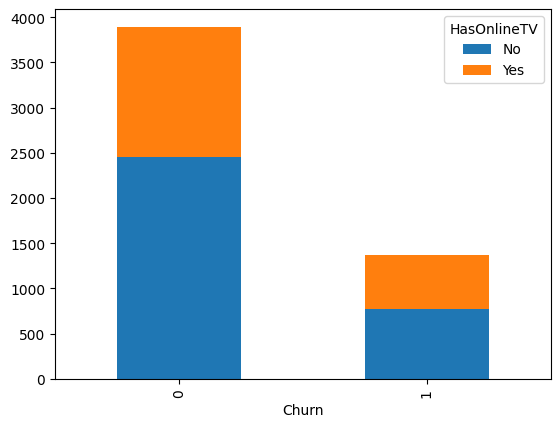

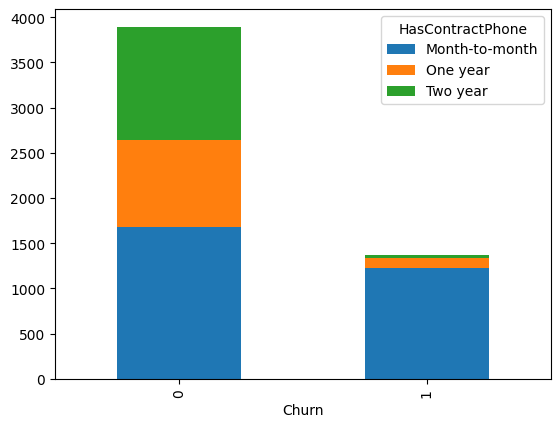

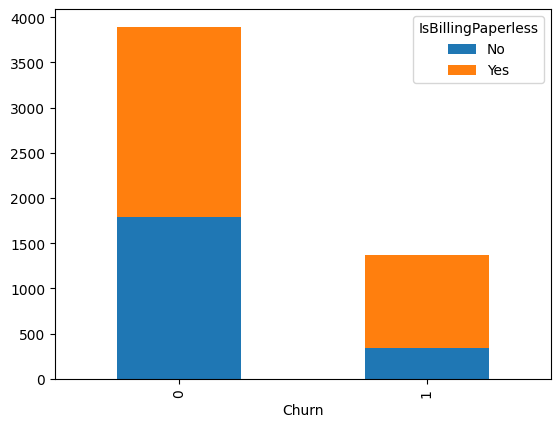

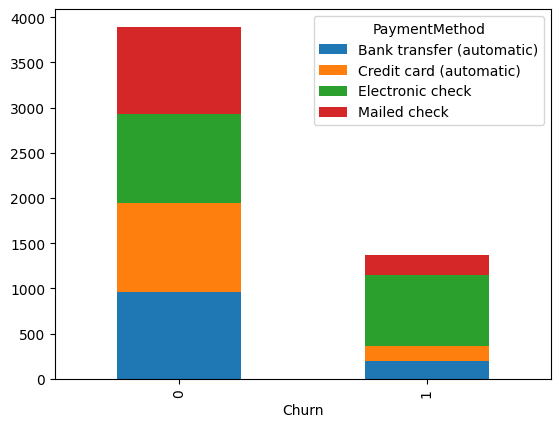

In [10]:
categorical_cols = [
    'HasChild',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod',
]

for col in categorical_cols:
    churn_by_category(col)

Колонки categorical_cols повышают метрику на 4%

In [11]:
def chi_test(col):
    ct = pd.crosstab(df[col], df['Churn'])
    statistic, pvalue, dof, expected  = st.chi2_contingency(ct)
    print(f"P-value: for {col}", pvalue)

In [12]:
cols = ["Sex", "IsSeniorCitizen", "HasPartner", "HasPhoneService", 'HasMovieSubscription'] + categorical_cols
for c in cols:
    chi_test(c)

P-value: for Sex 0.5768736341964421
P-value: for IsSeniorCitizen 3.863437007724606e-30
P-value: for HasPartner 3.4836186469174845e-26
P-value: for HasPhoneService 0.5019844674047159
P-value: for HasMovieSubscription 0.00014044418468952928
P-value: for HasChild 7.091784881034045e-32
P-value: for HasMultiplePhoneNumbers 0.0025030627783341384
P-value: for HasInternetService 7.273794373784286e-115
P-value: for HasOnlineSecurityService 1.573966602824722e-39
P-value: for HasOnlineBackup 4.5736174178764743e-10
P-value: for HasDeviceProtection 1.364613720380044e-06
P-value: for HasTechSupportAccess 1.1956962837748674e-32
P-value: for HasOnlineTV 9.086914418685944e-06
P-value: for HasContractPhone 7.250331956736594e-191
P-value: for IsBillingPaperless 2.2391937482381083e-44
P-value: for PaymentMethod 4.739912130247993e-101


Малые значения ни о чем не говорят.
Sex, HasPhoneService никак не влияют.

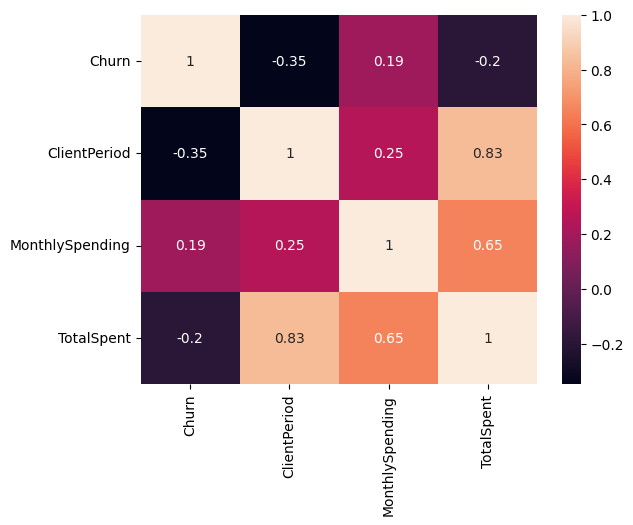

In [13]:
sns.heatmap(df[["Churn", "ClientPeriod", "MonthlySpending", "TotalSpent"]].corr(), annot=True);

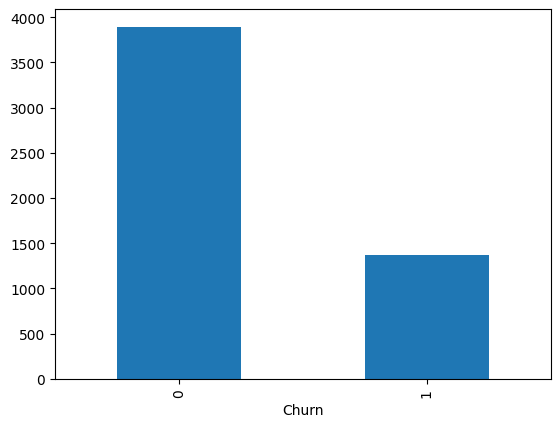

In [14]:
df["Churn"].value_counts().plot(kind="bar");

In [15]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.73918
1    0.26082
Name: proportion, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df["Churn"],
    test_size=0.2,
    random_state=79,
    shuffle=True,
    stratify=df["Churn"],
)

In [17]:
scaler_list = [
    None,
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
    PowerTransformer(),
    QuantileTransformer(random_state=79),
    QuantileTransformer(random_state=79, output_distribution='normal'),
]

drop_columns = ["Churn", "Sex", "IsSeniorCitizen", "HasPartner", "HasPhoneService", 'HasMovieSubscription']
columns_to_merge = ["ClientPeriod", "MonthlySpending", "TotalSpent"]
cols_for_encoding = categorical_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', drop_columns),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform='pandas'), cols_for_encoding),
        ('pca', PCA(n_components=2, random_state=79), columns_to_merge),
    ],
    remainder='passthrough',
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), # масштабирование
    # ('poly', PolynomialFeatures(interaction_only=True, degree=3, include_bias=False)),
    ('model', LogisticRegression(random_state=79, penalty="l2", max_iter=10000)),
])
params = {
    "scaler": scaler_list,
    'preprocessor__pca': [PCA(random_state=79), TruncatedSVD(random_state=79)],
    'preprocessor__pca__n_components':[1, 2, 3],
    "model__C": [10 ** x for x in range(-3, 4)],
}

gs = GridSearchCV(
    pipeline,
    params,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
)
gs.fit(X_train, y_train)
prediction = gs.predict_proba(X_test)
gs.best_score_

0.8481124240166074

0.8481124240166074

In [18]:
def class_separation(model):
    projection = model.fit_transform(X_train[["ClientPeriod", "MonthlySpending", "TotalSpent"]])
    print(model.explained_variance_ratio_)
    plt.scatter(projection[:,0], projection[:,1], c=y_train);

[9.99861421e-01 1.21682402e-04]


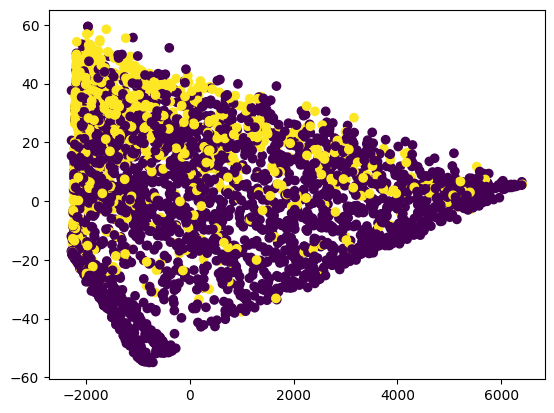

In [19]:
class_separation(PCA(n_components=2))

[9.99756964e-01 1.97336344e-04]


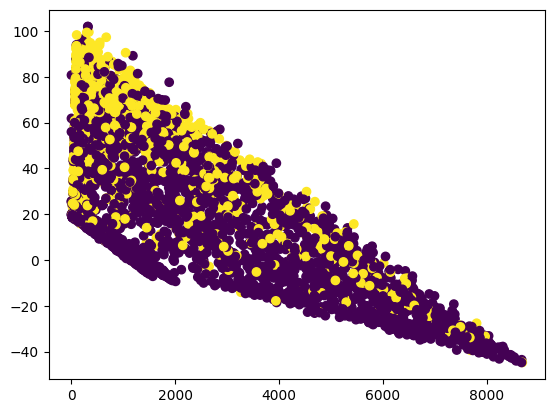

In [20]:
class_separation(TruncatedSVD(n_components=2))

In [21]:
lda = LinearDiscriminantAnalysis(n_components=1)
projection = lda.fit_transform(X_train[["ClientPeriod", "MonthlySpending", "TotalSpent"]], y_train)
lda.explained_variance_ratio_, projection

(array([1.]),
 array([[ 0.81781365],
        [ 1.83141509],
        [ 1.55773831],
        ...,
        [-0.94162953],
        [-0.78493389],
        [ 0.8409182 ]]))

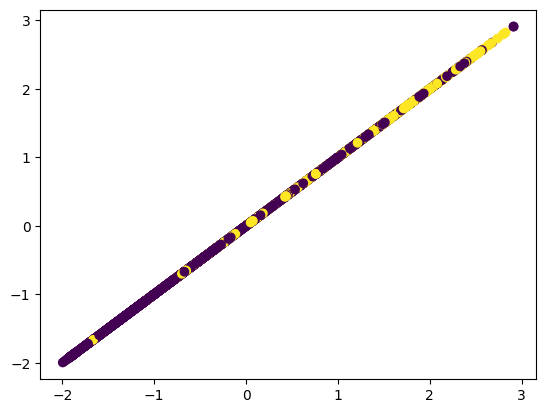

In [22]:
plt.scatter(projection[:,0], projection[:,0], c=y_train);

In [55]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', None),                
    ('model', None),
])
tree_params = {
    # 'scaler':scaler_list,
    'preprocessor__pca__n_components':[1, 2, 3],
    'model__max_depth':range(3, 8),
    'model__min_samples_split':range(2, 5),
    'model__min_samples_leaf':range(1, 5),
    "model__criterion": ["entropy", "gini"],
    "model__n_estimators": range(7, 12),
    "model": [
        # DecisionTreeClassifier(random_state=79),
        RandomForestClassifier(random_state=79),
        ExtraTreesClassifier(random_state=79),
    ],
}
tree_gs = GridSearchCV(pipe, tree_params, cv=4, scoring='roc_auc', n_jobs=-1)

In [58]:
tree_gs.fit(X_train, y_train)
tree_gs.best_score_

0.8415501565728696

0.8415501565728696

In [51]:
tree_gs.best_params_

{'model': RandomForestClassifier(random_state=79),
 'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 11,
 'preprocessor__pca__n_components': 2}

In [112]:
params = {
    'preprocessor__pca__n_components':[1, 2, 3],
    'model__max_depth':range(1, 5),
    'model__min_samples_split':range(2, 5),
    'model__min_samples_leaf':range(1, 5),
    "model__n_estimators": [10, 20, 50],
    "model__learning_rate": range(1, 4),
}

In [121]:
modelClf = GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=79, learning_rate=1)
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', None),                
    ('model', modelClf),
])
boost_gs = GridSearchCV(pipe, params, cv=4, scoring="roc_auc", n_jobs=-1)

In [ ]:
boost_gs.fit(X_train, y_train)
boost_gs.best_score_

In [ ]:
boost_gs.best_params_

In [ ]:
# test_df = pd.read_csv('test.csv')
# test_df["TotalSpent"] = test_df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
# test_df = test_df.astype({"TotalSpent": "float64"})
# test_df = pd.get_dummies(test_df, columns=categorical_cols)

In [ ]:
# sub_pred = gs.best_estimator_.predict_proba(test_df)

In [ ]:
# sub_pred[:, 1]

In [ ]:
# sub_df = pd.DataFrame(sub_pred[:, 1], columns=['Churn'])

In [ ]:
# sub_df.index.name = "Id"

In [ ]:
# sub_df

In [ ]:
# sub_df.to_csv("submission.csv")